Frame 99 | Time 9.9s | Weather: Clear
Collisions detected in frame: 0
ML Allocator updated: new relative velocity threshold = 69.0 m/s
t=9.9s | Vehicle  1: lane 0, pos= 490.1m, speed=29.2m/s | Mode=RF  | Slot= 2 | Freq=RF1      | Priority=False
t=9.9s | Vehicle  2: lane 1, pos= 479.0m, speed=27.6m/s | Mode=RF  | Slot= 3 | Freq=RF2      | Priority=False
t=9.9s | Vehicle  3: lane 1, pos= 131.0m, speed=21.2m/s | Mode=OCC | Slot= 4 | Freq=Optical2 | Priority=False
t=9.9s | Vehicle  4: lane 2, pos= 315.2m, speed=21.3m/s | Mode=RF  | Slot= 0 | Freq=RF2      | Priority=True
t=9.9s | Vehicle  5: lane 0, pos= 246.5m, speed=28.1m/s | Mode=RF  | Slot= 5 | Freq=RF2      | Priority=False
t=9.9s | Vehicle  6: lane 1, pos=  76.2m, speed=25.0m/s | Mode=OCC | Slot= 6 | Freq=Optical1 | Priority=False
t=9.9s | Vehicle  7: lane 0, pos= 415.4m, speed=20.1m/s | Mode=OCC | Slot= 7 | Freq=Optical2 | Priority=False
t=9.9s | Vehicle  8: lane 0, pos= 954.9m, speed=23.3m/s | Mode=OCC | Slot= 8 | Freq=Optical2 | P

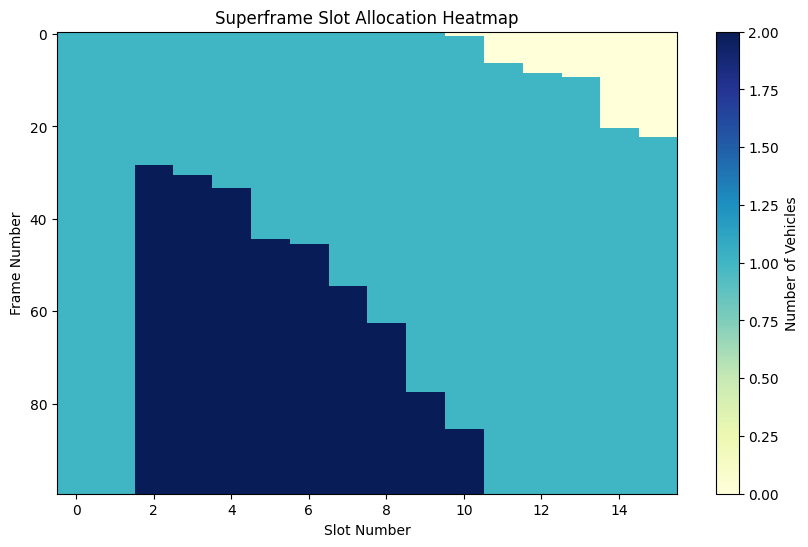

In [2]:
# Import required modules
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
import time
from IPython.display import clear_output

# ================================
# Global Simulation Parameters
# ================================

NUM_VEHICLES_INIT = 10            # initial number of vehicles
SIMULATION_FRAMES = 100           # total number of superframes to simulate
SUPERFRAME_DURATION = 0.1         # seconds per superframe (100 ms per frame)
ROAD_LENGTH = 1000                # length of the simulated road in meters
NUM_LANES = 3                     # number of lanes
SLOT_COUNT = 16                   # number of time slots per superframe
GTS_SLOTS = [0, 1]                # reserved slots for high priority (Guaranteed Time Slots)
OCC_RANGE = (1, 100)              # OCC effective range in meters
RF_RANGE = (100, 1000)            # RF effective range in meters
INIT_REL_VEL_THRESHOLD = 30       # initial relative velocity threshold (m/s) for switching to RF
COLLISION_DISTANCE = 50           # if two vehicles using the same slot/freq are closer than this, we mark a collision

# Define frequency channels for each mode
OCC_CHANNELS = ["Optical1", "Optical2"]
RF_CHANNELS  = ["RF1", "RF2", "RF3"]

# ================================
# Define Classes
# ================================

class Vehicle:
    """Represents a vehicle in the simulation."""
    def __init__(self, vid, pos, lane, speed, priority=False):
        self.id = vid
        self.pos = pos       # position along the road (meters)
        self.lane = lane     # lane number (0 to NUM_LANES-1)
        self.speed = speed   # speed in m/s
        self.priority = priority  # high-priority flag (e.g. emergency vehicle)
        self.comm_mode = None     # "OCC" or "RF"
        self.assigned_slot = None
        self.assigned_freq = None

    def update_position(self, dt):
        """Update vehicle position based on its speed and dt. Wrap-around at ROAD_LENGTH."""
        self.pos += self.speed * dt
        if self.pos > ROAD_LENGTH:
            # For simplicity, wrap around (simulate a circular road)
            self.pos = self.pos - ROAD_LENGTH

class MACScheduler:
    """A dynamic MAC layer scheduler using TDMA/FDMA."""
    def __init__(self, slot_count=SLOT_COUNT, gts_slots=GTS_SLOTS):
        self.slot_count = slot_count
        self.gts_slots = gts_slots

    def allocate_slots(self, vehicles):
        """
        Allocate slots (and frequency channels) to vehicles that need to transmit.
        Returns a dictionary mapping slot numbers to allocation info.
        The scheduler gives reserved GTS slots to high-priority vehicles.
        Other vehicles are assigned round-robin in remaining slots.
        """
        allocation = {slot: [] for slot in range(self.slot_count)}
        # First, assign GTS slots (reserved for high priority messages)
        high_priority = [v for v in vehicles if v.priority]
        for slot in self.gts_slots:
            if high_priority:
                # If there are more than one, assign the first high priority vehicle and remove it
                veh = high_priority.pop(0)
                veh.assigned_slot = slot
                veh.assigned_freq = self.select_frequency(veh.comm_mode)
                allocation[slot].append({'veh_id': veh.id, 'mode': veh.comm_mode, 'freq': veh.assigned_freq})

        # Now assign remaining vehicles (normal priority)
        normal_priority = [v for v in vehicles if v.assigned_slot is None]
        # For simplicity, assign sequentially from slot= max(gts)+1 onward, wrapping around if necessary
        slot = max(self.gts_slots) + 1
        for veh in normal_priority:
            veh.assigned_slot = slot
            veh.assigned_freq = self.select_frequency(veh.comm_mode)
            allocation[slot].append({'veh_id': veh.id, 'mode': veh.comm_mode, 'freq': veh.assigned_freq})
            slot += 1
            if slot >= self.slot_count:
                slot = max(self.gts_slots) + 1  # skip reserved slots
        return allocation

    def select_frequency(self, mode):
        """Select a frequency channel based on communication mode."""
        if mode == "OCC":
            return random.choice(OCC_CHANNELS)
        else:
            return random.choice(RF_CHANNELS)

class MLResourceAllocator:
    """
    A dummy ML module to adjust resource allocation parameters.
    For example, it adjusts the relative velocity threshold based on observed collisions.
    """
    def __init__(self, init_threshold=INIT_REL_VEL_THRESHOLD):
        self.rel_vel_threshold = init_threshold
        self.frame_collision_history = []

    def update(self, collisions):
        """Update the relative velocity threshold based on collision count.
           If many collisions occur, increase threshold (favor RF); if none, slowly decrease it."""
        self.frame_collision_history.append(collisions)
        # Use a simple rule: if collisions > 0, increase threshold by 5 m/s; if zero collisions for last 5 frames, decrease threshold by 2 m/s.
        if collisions > 0:
            self.rel_vel_threshold += 5
        elif len(self.frame_collision_history) >= 5 and all(c == 0 for c in self.frame_collision_history[-5:]):
            self.rel_vel_threshold = max(10, self.rel_vel_threshold - 2)
        # Print ML update log
        print(f"ML Allocator updated: new relative velocity threshold = {self.rel_vel_threshold:.1f} m/s")
        return self.rel_vel_threshold

# ================================
# Helper Functions
# ================================

def get_current_weather(frame):
    """
    Simulate weather conditions.
    For simplicity, weather changes every 20 frames.
    Possible weather: "Clear", "Rain", "Fog", "Snow".
    """
    weather_states = ["Clear", "Rain", "Fog", "Snow"]
    index = (frame // 20) % len(weather_states)
    return weather_states[index]

def select_mode(veh, target, weather, rel_vel_threshold):
    """
    Decide whether to use OCC or RF between veh and its target.
    Conditions:
      - If distance is within OCC range (1-100m) and weather is clear AND relative velocity < threshold -> OCC.
      - Else, use RF.
    """
    # Compute distance (absolute difference, assuming same lane for simplicity)
    distance = abs(target.pos - veh.pos)
    # Compute relative velocity
    rel_vel = abs(target.speed - veh.speed)

    # Also, adverse weather (Rain, Fog, Snow) degrade OCC.
    if weather != "Clear":
        return "RF"
    # If distance is out of OCC range, use RF.
    if not (OCC_RANGE[0] <= distance <= OCC_RANGE[1]):
        return "RF"
    # If relative velocity is too high, use RF.
    if rel_vel > rel_vel_threshold:
        return "RF"
    return "OCC"

def find_nearest_vehicle(veh, vehicles):
    """
    For a given vehicle, find the nearest vehicle ahead in the same lane.
    If none is found, return a dummy RSU target located at a fixed position.
    """
    same_lane = [v for v in vehicles if v.lane == veh.lane and v.id != veh.id]
    # Only consider vehicles ahead (i.e. with pos > veh.pos) and compute distance
    ahead = [v for v in same_lane if v.pos > veh.pos]
    if ahead:
        nearest = min(ahead, key=lambda v: v.pos - veh.pos)
        return nearest
    else:
        # Create a dummy target representing a roadside unit (RSU) at position ROAD_LENGTH (simulate an RSU at end-of-road)
        dummy = Vehicle(vid="RSU", pos=ROAD_LENGTH, lane=veh.lane, speed=0)
        return dummy

def check_collisions(allocation, vehicles):
    """
    Check for collisions: if two vehicles assigned the same slot and same frequency are too close (< COLLISION_DISTANCE)
    then count a collision.
    Returns the total collision count in this frame.
    """
    collisions = 0
    # For each slot, if more than one allocation exists, check distances between all pairs.
    for slot, allocs in allocation.items():
        if len(allocs) > 1:
            # Get vehicles corresponding to this slot allocation
            vehs = [v for v in vehicles if v.assigned_slot == slot]
            for i in range(len(vehs)):
                for j in range(i+1, len(vehs)):
                    if vehs[i].assigned_freq == vehs[j].assigned_freq:
                        if abs(vehs[i].pos - vehs[j].pos) < COLLISION_DISTANCE:
                            collisions += 1
    return collisions

# ================================
# Simulation Environment
# ================================

class Simulation:
    def __init__(self):
        self.vehicles = []
        self.frame_logs = []  # log of MAC allocations per frame
        self.vehicle_logs = []  # log of each vehicle's status per frame
        self.mac_scheduler = MACScheduler()
        self.ml_allocator = MLResourceAllocator()
        self.current_frame = 0
        self.next_vehicle_id = 1
        self.initialize_vehicles(NUM_VEHICLES_INIT)

    def initialize_vehicles(self, num):
        """Create initial vehicles with random positions, lanes, and speeds."""
        for _ in range(num):
            pos = random.uniform(0, ROAD_LENGTH)
            lane = random.randint(0, NUM_LANES - 1)
            speed = random.uniform(20, 30)  # in m/s (~72-108 km/h)
            # Randomly mark some vehicles as high-priority (say 10% chance)
            priority = True if random.random() < 0.1 else False
            veh = Vehicle(self.next_vehicle_id, pos, lane, speed, priority)
            self.vehicles.append(veh)
            self.next_vehicle_id += 1

    def add_vehicle(self):
        """Add a new vehicle at the beginning of the road."""
        pos = 0
        lane = random.randint(0, NUM_LANES - 1)
        speed = random.uniform(20, 30)
        priority = True if random.random() < 0.1 else False
        veh = Vehicle(self.next_vehicle_id, pos, lane, speed, priority)
        self.vehicles.append(veh)
        self.next_vehicle_id += 1

    def run(self):
        """Run the simulation for a number of superframes."""
        for frame in range(SIMULATION_FRAMES):
            clear_output(wait=True)
            current_time = frame * SUPERFRAME_DURATION
            weather = get_current_weather(frame)
            print(f"Frame {frame} | Time {current_time:.1f}s | Weather: {weather}")

            # Possibly add a new vehicle randomly
            if random.random() < 0.2:
                self.add_vehicle()

            # Update positions of vehicles
            for veh in self.vehicles:
                veh.update_position(SUPERFRAME_DURATION)

            # For each vehicle, determine its communication target (nearest vehicle ahead or RSU)
            for veh in self.vehicles:
                target = find_nearest_vehicle(veh, self.vehicles)
                # Use ML-adjusted relative velocity threshold from the ML module
                veh.comm_mode = select_mode(veh, target, weather, self.ml_allocator.rel_vel_threshold)

            # Allocate MAC slots using the scheduler (reset assigned_slot for this frame first)
            for veh in self.vehicles:
                veh.assigned_slot = None
                veh.assigned_freq = None
            allocation = self.mac_scheduler.allocate_slots(self.vehicles)

            # Check for collisions (simple interference check)
            collisions = check_collisions(allocation, self.vehicles)
            print(f"Collisions detected in frame: {collisions}")
            # Update ML module with collision count (adjust relative velocity threshold)
            new_threshold = self.ml_allocator.update(collisions)

            # Log vehicle statuses for this frame
            frame_status = []
            for veh in self.vehicles:
                status = {
                    "Frame": frame,
                    "Time(s)": current_time,
                    "Vehicle_ID": veh.id,
                    "Lane": veh.lane,
                    "Position(m)": round(veh.pos,1),
                    "Speed(m/s)": round(veh.speed,1),
                    "Comm_Mode": veh.comm_mode,
                    "Slot": veh.assigned_slot,
                    "Freq": veh.assigned_freq,
                    "Priority": veh.priority
                }
                frame_status.append(status)
                print(f"t={current_time:.1f}s | Vehicle {veh.id:2}: lane {veh.lane}, pos={veh.pos:6.1f}m, "
                      f"speed={veh.speed:4.1f}m/s | Mode={veh.comm_mode:3} | Slot={veh.assigned_slot:2} | Freq={veh.assigned_freq:8} | Priority={veh.priority}")
            self.vehicle_logs.extend(frame_status)

            # Log MAC allocation for the frame
            frame_alloc = {"Frame": frame, "Allocation": allocation, "Weather": weather}
            self.frame_logs.append(frame_alloc)

            # Wait for real-time pacing (optional – uncomment to slow simulation)
            # time.sleep(SUPERFRAME_DURATION)

            self.current_frame += 1

        print("Simulation completed.")

    def get_vehicle_log_df(self):
        """Return a pandas DataFrame of vehicle status logs."""
        return pd.DataFrame(self.vehicle_logs)

    def get_allocation_log_df(self):
        """Return a DataFrame summarizing slot allocation per frame."""
        # For each frame, create a row with slot numbers as columns.
        rows = []
        for log in self.frame_logs:
            row = {"Frame": log["Frame"], "Weather": log["Weather"]}
            alloc = log["Allocation"]
            for slot in range(SLOT_COUNT):
                # Create a string summary of allocations in this slot
                if alloc[slot]:
                    entries = [f"V{entry['veh_id']}({entry['mode']},{entry['freq']})" for entry in alloc[slot]]
                    row[f"Slot_{slot}"] = ", ".join(entries)
                else:
                    row[f"Slot_{slot}"] = ""
            rows.append(row)
        return pd.DataFrame(rows)

    def plot_superframe_heatmap(self):
        """Plot a heatmap showing how many vehicles are allocated in each slot over frames."""
        # Create a matrix: rows = frames, columns = slots; value = number of vehicles assigned
        data = np.zeros((SIMULATION_FRAMES, SLOT_COUNT))
        for log in self.frame_logs:
            frame = log["Frame"]
            alloc = log["Allocation"]
            for slot in range(SLOT_COUNT):
                data[frame, slot] = len(alloc[slot])
        plt.figure(figsize=(10, 6))
        plt.imshow(data, cmap="YlGnBu", aspect="auto")
        plt.colorbar(label="Number of Vehicles")
        plt.xlabel("Slot Number")
        plt.ylabel("Frame Number")
        plt.title("Superframe Slot Allocation Heatmap")
        plt.show()

# ================================
# Run the Simulation
# ================================

sim = Simulation()
sim.run()

# Generate logs as DataFrames
vehicle_df = sim.get_vehicle_log_df()
allocation_df = sim.get_allocation_log_df()

print("\n--- Vehicle Log Summary ---")
print(vehicle_df.head(20))

print("\n--- MAC Allocation Summary ---")
print(allocation_df.head(10))

# Plot a heatmap of slot allocation over time
sim.plot_superframe_heatmap()
